In [1]:
!pip install -r requirements.txt
# !pip install graphviz pydot

Defaulting to user installation because normal site-packages is not writeable


In [2]:
""" Imports"""

import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf
import os

from tensorflow import keras
from tensorflow.keras import layers, mixed_precision
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.utils import plot_model
import pathlib
import numpy as np
import pandas as pd

from sklearn.metrics import confusion_matrix, classification_report, jaccard_score
import numpy as np
import itertools
import random

from tensorflow.python.client import device_lib 
# print(device_lib.list_local_devices())

!nvidia-smi -L

# Load the TensorBoard notebook extension.
%load_ext tensorboard

# multi GPU strategy
strategy = tf.distribute.MirroredStrategy() # you can define which gpus to use tf.distribute.MirroredStrategy(devices=["/gpu:0", "/gpu:1"])

# mixed precision policy
mixed_precision.set_global_policy('mixed_float16') # On TPUs, use 'mixed_bfloat16'

print('Number of devices: {}'.format(strategy.num_replicas_in_sync))

2022-11-08 11:54:40.544359: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-08 11:54:40.672736: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-11-08 11:54:41.263077: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/nvidia/hpc_sdk/Linux_x86_64/21.11/comm_libs/nccl/lib:/global/common/software/nersc/pm-2021q4/sw/cudnn/8.3.2-cuda11.5/lib:/opt/nvidia/hpc_sdk/Linux_x86_64/21.11/math_libs/11.5/lib64:/opt/nvidia/hpc_sdk/Linux_

GPU 0: NVIDIA A100-SXM4-40GB (UUID: GPU-6954accf-a07b-d2db-5b73-46b68471041e)
GPU 1: NVIDIA A100-SXM4-40GB (UUID: GPU-786165a5-0f27-5ddb-f612-7da11da5b067)
GPU 2: NVIDIA A100-SXM4-40GB (UUID: GPU-57de6f82-d73e-2cec-50df-39f707950212)
GPU 3: NVIDIA A100-SXM4-40GB (UUID: GPU-8bce9063-fc55-a7d0-3154-046540515aad)


2022-11-08 11:54:43.813227: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-08 11:54:45.675491: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 38258 MB memory:  -> device: 0, name: NVIDIA A100-SXM4-40GB, pci bus id: 0000:03:00.0, compute capability: 8.0
2022-11-08 11:54:45.676887: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 38258 MB memory:  -> device: 1, name: NVIDIA A100-SXM4-40GB, pci bus id: 0000:41:00.0, compute capability: 8.0
2022-11-08 11:54:45.678152: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /job:localhost/replica:0/task:0/devi

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1', '/job:localhost/replica:0/task:0/device:GPU:2', '/job:localhost/replica:0/task:0/device:GPU:3')
INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPUs will likely run quickly with dtype policy mixed_float16 as they all have compute capability of at least 7.0
Number of devices: 4


In [3]:
# Functions

def plot_confusion_matrix(cm, classes,
                          normalize=True,#False
                          title='Confusion matrix',
                          cmap=plt.cm.Blues,
                          verbose=False):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        if verbose:
            print("Normalized confusion matrix")
    else:
        if verbose:
            print('Confusion matrix, without normalization')
    if verbose:
        print(cm)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes, rotation=45)
    fmt = '.2f' if normalize else 'd'
    thresh = (cm.max()+cm.min()) / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    #plt.rcParams["figure.figsize"] = [4, 4]
    plt.savefig('Confusion_matrix.pdf', bbox_inches = 'tight')
    plt.show() 

# Define a callback for printing the learning rate at the end of each epoch.
class PrintLR(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs=None):
    print('\nLearning rate for epoch {} is {}'.format(        epoch + 1, model.optimizer.lr.numpy()))


In [4]:
# Get datasets, preview and plot some
dataset_dir = "./Training_Dataset"
data_dir = pathlib.Path(dataset_dir)
print(data_dir)

image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

batch_size_per_replica = 16
img_height = 1024
img_width = 1024

buffer_size = 4000
batch_size = batch_size_per_replica * strategy.num_replicas_in_sync

Training_Dataset
2207


Found 2207 files belonging to 2 classes.
Using 1435 files for training.
Found 2207 files belonging to 2 classes.
Using 772 files for validation.
['hollow_heart', 'other_potatoes']
(64, 1024, 1024, 3)
(64,)


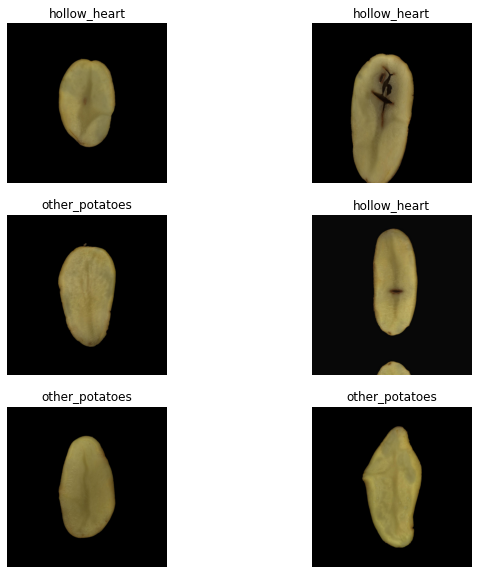

In [5]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.35,
    subset="training",
    labels='inferred',
    label_mode='int',
    seed=123,
    shuffle=True,
    color_mode = 'rgb',
    image_size=(img_height, img_width),
    interpolation='bilinear',
    batch_size=batch_size)

val_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.35,
    subset="validation",
    labels='inferred',
    label_mode='int',
    seed=123,
    shuffle=True,
    color_mode = 'rgb',
    image_size=(img_height, img_width),
    interpolation='bilinear',
    batch_size=batch_size)


class_names = train_ds.class_names
print(class_names)


plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(6):
    ax = plt.subplot(3, 2, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break   

In [6]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(buffer_size).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)


normalization_layer = layers.Rescaling(1./255)
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0 0.689


In [7]:
""" 
Model(s)
"""
num_classes = len(class_names)

choice = 3 # for custom model[0], Resnet50[1], ConvNext[2], EfficientNetv2[3]
# Note: ConvNext is not compatible with mixed precision
model_folder = 'EfficientNetv2_1024/'

nf = 16
shape = (img_height, img_width, 3)

with strategy.scope():
    
    in_layer = layers.Input(shape = shape)
    top_layer = layers.Rescaling(1./255)(in_layer)
    
    if choice == 0:
        # Custom model
        b_model = Sequential([
            layers.Conv2D(nf, 3, padding='same', activation='relu',input_shape=shape),
            layers.BatchNormalization(),
            layers.MaxPooling2D(),
            layers.Conv2D(2*nf, 3, padding='same', activation='relu'),
            layers.BatchNormalization(),
            layers.MaxPooling2D(),
            layers.Conv2D(4*nf, 3, padding='same', activation='relu'),
            layers.BatchNormalization(),
            layers.MaxPooling2D(),
            layers.Conv2D(8*nf, 3, padding='same', activation='relu'),
            layers.BatchNormalization(),
            layers.MaxPooling2D(),
            layers.Conv2D(16*nf, 3, padding='same', activation='relu'),
            layers.BatchNormalization(),
            layers.MaxPooling2D(),
            layers.Conv2D(32*nf, 3, padding='same', activation='relu'),
            layers.BatchNormalization()
        ])
    
    # Other prebuilt architectures from KERAS (performance =  https://keras.io/api/applications/)
    elif choice == 1:
        # 1 Resnet50 V2 (https://arxiv.org/abs/1603.05027)
        b_model = tf.keras.applications.resnet_v2.ResNet50V2(include_top=False,
                                                             weights=None,
                                                             input_tensor=None,
                                                             input_shape=shape)
            
    elif choice == 2:
        # 2 ConvNext-small (https://arxiv.org/abs/2201.03545)
        b_model = tf.keras.applications.convnext.ConvNeXtSmall(weights=None,
                                                               include_top=False,
                                                               input_tensor=None,
                                                               input_shape=shape)
            
    elif choice == 3:
        # 4 EfficientNetv2 (https://arxiv.org/abs/2104.00298)
        b_model = tf.keras.applications.EfficientNetV2B0(weights=None,
                                                         include_top=False,
                                                         input_tensor=None,
                                                         input_shape=shape)
    
    X = b_model(top_layer)
    
    X = layers.GlobalAveragePooling2D()(X)
    X = layers.Flatten()(X)
    X = layers.Dropout(0.2)(X)
    
    X = layers.Dense(1024, activation = 'relu')(X)
    X = layers.BatchNormalization()(X)
    # X = layers.Dropout(0.2)(X)
    
    X = layers.Dense(128, activation = 'relu')(X)
    X = layers.BatchNormalization()(X)
    # X = layers.Dropout(0.2)(X)
    
    X = layers.Dense(16, activation = 'relu')(X)
    X = layers.BatchNormalization()(X)
    # X = layers.Dropout(0.2)(X)
    
    X = layers.Dense(num_classes)(X)
    outputs = layers.Activation('relu', dtype='float32', name='outputs')(X)
    
    
    model = tf.keras.Model(in_layer, outputs)
    
    optimizer = keras.optimizers.Adam(
                    learning_rate = 0.001,
                    beta_1 = 0.90,
                    beta_2 = 0.999,
                    epsilon = 1e-07,
                    amsgrad = True,
                    name='Adam')
    optimizer = tf.keras.mixed_precision.LossScaleOptimizer(optimizer)
    
    loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
    # optimizer.minimize(loss_fn, var_list=var)
    
    model.compile(optimizer=optimizer, 
                  loss=loss_fn,
                  metrics=['accuracy'])

model.summary()
plot_model(model, to_file=model_folder+'model_plot.png', show_shapes=True, show_layer_names=True)

INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Redu

In [ ]:
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
# In detail:-
# 0 = all messages are logged (default behavior)
# 1 = INFO messages are not printed
# 2 = INFO and WARNING messages are not printed
# 3 = INFO, WARNING, and ERROR messages are not printed

checkpoint_path = model_folder + "cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)


# Create a callback that saves the model's weights
# cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
#                                                  save_weights_only=True,
#                                                  verbose=1)

with strategy.scope():
    cp_callback = [
        tf.keras.callbacks.TensorBoard(log_dir = model_folder+'logs',
                                    update_freq='epoch'),
        tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                        save_weights_only=True,
                                        verbose=1),
        tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',
                                            factor=0.95,
                                            patience=10,
                                            verbose=1,
                                            mode='auto',
                                            cooldown=5,
                                            min_lr=0),
        PrintLR(),
    ]

# train_dataset = strategy.experimental_distribute_dataset(train_ds) 
# valid_dataset = strategy.experimental_distribute_dataset(val_ds)

# %tensorboard --logdir=logs --host localhost --port 8088 # http://localhost:8088
%tensorboard --logdir=model_folder+'logs'

epochs = 400
history = model.fit(
    train_ds,
    validation_data = val_ds,
    epochs = epochs,
    callbacks=[cp_callback]
)

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

# plt.figure(figsize=(8, 8))
plt.figure(21)
# plt.subplot(2, 1, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.figure(22)
# plt.subplot(2, 1, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

hist_df = pd.DataFrame(history.history)
hist_df.to_csv(model_folder+'history.csv')

# Evaluate the model
loss, acc = model.evaluate(test_dataset, verbose=2)
print("Trained model, accuracy: {:5.2f}%".format(100 * acc))

# Alternative save whole model
model.save(model_folder+'my_model.h5')

2022-11-08 11:58:13.295299: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:776] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Found an unshardable source dataset: name: "TensorSliceDataset/_1"
op: "TensorSliceDataset"
input: "Placeholder/_0"
attr {
  key: "Toutput_types"
  value {
    list {
      type: DT_STRING
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: 1435
  }
}
attr {
  key: "is_files"
  value {
    b: false
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\024TensorSliceDataset:0"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
      }
    }
  }
}
attr {
  key: "replicate_on_split"
  value {
    b: false
  }
}
experimental_type {
  type_id: TFT_PRODUCT
  args {
    type_id: TFT_DATASET
    args {
      type_id: TFT_PRODUCT
      args {
        type_id: TFT_TENSOR
        args {
          type_id: TFT_STRING
        }
      }
    }
  }
}



Epoch 1/400
INFO:tensorflow:batch_all_reduce: 255 all-reduces with algorithm = nccl, num_packs = 1
INFO:tensorflow:batch_all_reduce: 255 all-reduces with algorithm = nccl, num_packs = 1


2022-11-08 11:59:19.089241: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8302
2022-11-08 11:59:19.825241: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8302
2022-11-08 11:59:20.630558: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8302
2022-11-08 11:59:21.224368: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8302


23/23 [==============================] - ETA: 0s - loss: 0.7260 - accuracy: 0.5199

2022-11-08 11:59:38.553838: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:776] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Found an unshardable source dataset: name: "TensorSliceDataset/_1"
op: "TensorSliceDataset"
input: "Placeholder/_0"
attr {
  key: "Toutput_types"
  value {
    list {
      type: DT_STRING
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: 772
  }
}
attr {
  key: "is_files"
  value {
    b: false
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\024TensorSliceDataset:7"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
      }
    }
  }
}
attr {
  key: "replicate_on_split"
  value {
    b: false
  }
}
experimental_type {
  type_id: TFT_PRODUCT
  args {
    type_id: TFT_DATASET
    args {
      type_id: TFT_PRODUCT
      args {
        type_id: TFT_TENSOR
        args {
          type_id: TFT_STRING
        }
      }
    }
  }
}




Epoch 1: saving model to EfficientNetv2_1024/cp.ckpt

Learning rate for epoch 1 is 0.0010000000474974513
23/23 [==============================] - 95s 824ms/step - loss: 0.7260 - accuracy: 0.5199 - val_loss: 0.6786 - val_accuracy: 0.5959 - lr: 0.0010
Epoch 2/400
23/23 [==============================] - ETA: 0s - loss: 0.6634 - accuracy: 0.5366
Epoch 2: saving model to EfficientNetv2_1024/cp.ckpt
23/23 [==============================] - ETA: 0s - loss: 0.3800 - accuracy: 0.7624
Epoch 5: saving model to EfficientNetv2_1024/cp.ckpt

Learning rate for epoch 5 is 0.0010000000474974513
23/23 [==============================] - 9s 410ms/step - loss: 0.3800 - accuracy: 0.7624 - val_loss: 39.3120 - val_accuracy: 0.4041 - lr: 0.0010
Epoch 6/400
23/23 [==============================] - ETA: 0s - loss: 0.3295 - accuracy: 0.8188
Epoch 6: saving model to EfficientNetv2_1024/cp.ckpt

Learning rate for epoch 6 is 0.0010000000474974513
23/23 [==============================] - 9s 413ms/step - loss: 0.329

In [ ]:
# Prediction on single image
# checkpoint_path = "training_1/cp.ckpt"
# model.load_weights(checkpoint_path)

model_folder = 'EfficientNetV2_1024/'

# Or load saved model
model = tf.keras.models.load_model(model_folder+'my_model.h5')
model.summary() # Preview model architecture

img_height = 1024
img_width = 1024


In [ ]:
#load test dataset
t_data_dir = './Test_Dataset'
test_dataset = tf.keras.utils.image_dataset_from_directory(
    t_data_dir,
    validation_split=None,
    labels='inferred',
    label_mode='int',
    seed=123,
    shuffle=True,        #or False
    color_mode = 'rgb',
    interpolation='bilinear',
    image_size=(img_height, img_width))

# Evaluate model performance on test set
loss, acc = model.evaluate(test_dataset, verbose=2)
n_test = len(test_dataset.file_paths)
print("Test dataset = ",n_test,"images")
print("Model, accuracy: {:5.2f}%".format(100 * acc))


predicted = model.predict(test_dataset)
y_classes = predicted.argmax(axis=-1)

test_label = np.concatenate([y for x, y in test_dataset], axis=0) 
real = test_label
cm = confusion_matrix(y_classes, real)
classes = test_dataset.class_names
plot_confusion_matrix(cm, classes, normalize=False, cmap=plt.cm.Blues)

print(classification_report(real,y_classes)) # F1 Score, Precision Score, Recall Score

j_index = jaccard_score(real,y_classes,average='micro') # jaccard score
print('Jaccard Score = ',round(j_index,2))


plt.figure(figsize=(10, 10))
rand_idx = random.sample(range(n_test),6) #preview 6 random images
for i in range(6):
    file_path = test_dataset.file_paths[rand_idx[i]]
    img = tf.keras.utils.load_img(
        file_path, target_size=(img_height, img_width)
    )

    imgg = np.array(img, dtype = "uint8")

    img_array = tf.keras.utils.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0) # Create a batch

    predictions = model.predict(img_array)
    score = tf.nn.softmax(predictions[0])


    ax = plt.subplot(3, 2, i + 1)
    plt.imshow(imgg)
    plt.title(class_names[np.argmax(score)]+' : ' + str(round(100 * np.max(score),2))+ '% confidence')
    plt.axis("off")
